In [1]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re, sys

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
# sys.path.insert(1, '/path/to/application/app/folder')
from utility import *
# import gaussian_kde

# import warnings
# warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline



Toggle code

In [2]:
dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"

Manifesto_Project_Dataset_version_2019b = "MPDataset_MPDS2019b_stata14.dta"

In [3]:
manifesto_project = pd.read_pickle(dataset_folder+Manifesto_Project_Dataset_version_2019b.replace("dta","zip"),compression='zip')

In [6]:
Treatment = "Manifesto Project Decomposition"
output_subfolder = output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [7]:
# reader = pd.io.stata.StataReader(dataset_folder+Manifesto_Project_Dataset_version_2019b)

# header = reader.variable_labels()
# labels = reader.value_labels()

# # Manifesto_Project_Dataset_version_2019b
# pd.Series(header).to_pickle(dataset_folder+Manifesto_Project_Dataset_version_2019b.replace(".dta","_variable_labels.zip"),compression='zip')

# fn = dataset_folder+Manifesto_Project_Dataset_version_2019b.replace(".dta","_value_labels.pkl")
# with open(fn, "wb") as f: pickle.dump( labels, f )

In [8]:
variable_labels = pd.read_pickle(dataset_folder+Manifesto_Project_Dataset_version_2019b.replace(".dta","_variable_labels.zip"),compression='zip')
fn = dataset_folder+Manifesto_Project_Dataset_version_2019b.replace(".dta","_value_labels.pkl")
with open(fn, "rb") as f: value_labels = pickle.load(f) 

In [52]:
value_vars = [x for x in manifesto_project.columns if re.match("per(\d+|uncod)|rile|planeco|markeco|welfare|intpeace",x)]
# rile, planeco, markeco, welfare, intpeace
MCP_vals = manifesto_project[value_vars]
MCP_vals = MCP_vals.fillna(MCP_vals.mean())
# df["peruncod"]
# percentage uncoded
MCP_vals.columns = [variable_labels.loc[x]+"("+x.replace("per","")+")" for x in MCP_vals.columns]
# MCP_vals.columns
MCP_vals = MCP_vals.drop_duplicates()

In [53]:
decomp_index = MCP_vals.index
decomp_columns = MCP_vals.columns
clean_feature_set_std = StandardScaler().fit_transform(MCP_vals.values )
decomp_std = pd.DataFrame(   clean_feature_set_std,
                             columns = MCP_vals.columns,
                             index   = MCP_vals.index      )

In [63]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = decomp_std.shape[1]
n_components = 3
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(decomp_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = decomp_index)


Wall time: 39.2 s


In [64]:
import pickle
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    decomp_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    decomp_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

Warning, filename truncated because it was over 30. Filenames may no longer be unique


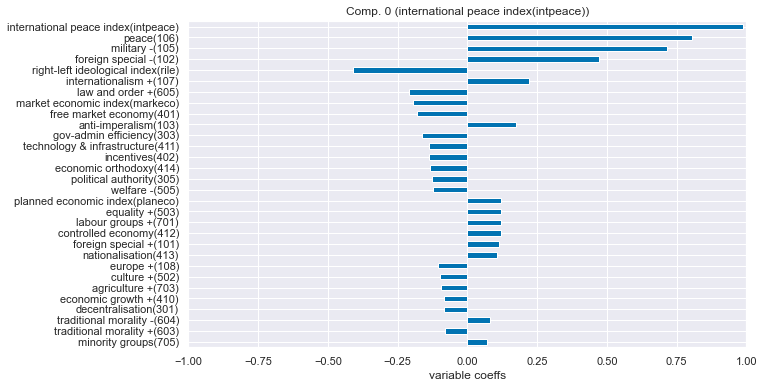

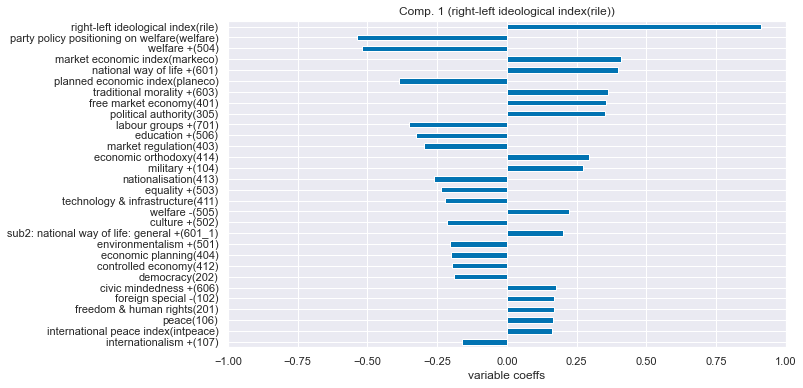

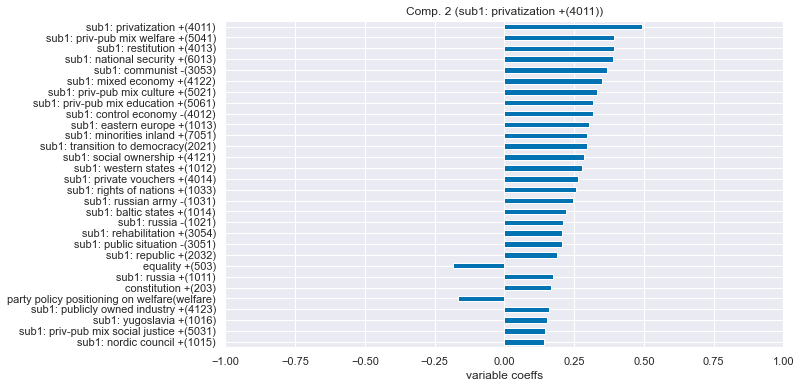

In [65]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          decomp_columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [50]:
MCP_vals = MCP_vals.drop_duplicates()

Automatically created module for IPython interactive environment
best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5
best n_components by PCA CV = 18
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 17
best n_components by PCA CV = 0
best n_components by FactorAnalysis CV = 3
best n_components by PCA MLE = 147


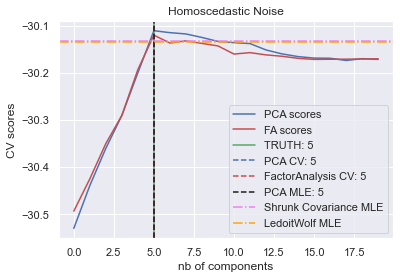

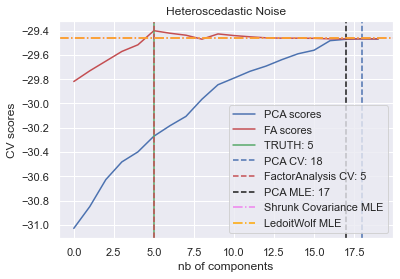

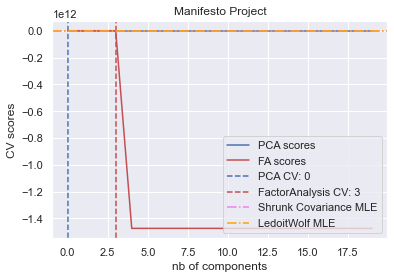

Wall time: 5min 1s


In [51]:
%%time
# Authors: Alexandre Gramfort
#          Denis A. Engemann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Create the data

n_samples, n_features, rank = 1000, 20, 5
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 1)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


decomp_index = MCP_vals.index
decomp_columns = MCP_vals.columns
clean_feature_set_std = StandardScaler().fit_transform(MCP_vals.values )
decomp_std = pd.DataFrame(   clean_feature_set_std,
                             columns = MCP_vals.columns,
                             index   = MCP_vals.index      )


for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise'),
                 (decomp_std.values, 'Manifesto Project')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    if title in [ 'Homoscedastic Noise','Heteroscedastic Noise']:
        plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    if title in [ 'Homoscedastic Noise','Heteroscedastic Noise']:    
        plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

In [25]:
n_components_pca

35

In [18]:
(MCP_vals.values,'Manifesto Project')

(array([[ 4.86485357,  1.9       ,  0.        , ...,  1.9       ,
          0.        ,  1.9       ],
        [ 4.86485357,  1.1       ,  0.        , ...,  2.2       ,
         33.4       ,  5.6       ],
        [ 4.86485357,  3.2       ,  0.        , ...,  6.4       ,
         14.3       ,  1.6       ],
        ...,
        [ 0.        ,  0.142     ,  0.        , ...,  0.427     ,
         13.675     ,  0.142     ],
        [ 0.        ,  1.042     ,  0.        , ...,  0.        ,
         10.938     ,  2.083     ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          6.098     ,  0.        ]]),
 'Manifesto Project')

In [23]:
MCP_vals.shape

(4492, 148)

In [24]:
n_components

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [30]:
fa_scores

[-649979.6753497024,
 -1473293858958.237,
 -1473293859026.2976,
 -1473293859732.689]

In [33]:
MCP_vals

percent of uncoded quasi-sentences (000)(uncod)  \
id_perm                                                    
JN1LZH                                          4.864854   
CMR7F6                                          4.864854   
Z6OL6C                                          4.864854   
YMKVN2                                          4.864854   
U4SCRD                                         42.857000   
...                                                  ...   
FYLAK1                                          0.000000   
SES5XV                                          0.000000   
MEH5KV                                          0.000000   
NU5PXG                                          0.000000   
VKSFXI                                          0.000000   

         foreign special +(101)  foreign special -(102)  anti-imperalism(103)  \
id_perm                                                                         
JN1LZH                    1.900                     0.0                 0.000   
CMR7F6                    1.100                     0.0                 0.000   
Z6OL6C                    3.200                     0.0                 0.000   
YMKVN2                    1.800                     0.0                 0.000   
U4SCRD                    0.000                     0.0                 0.000   
...                         ...                     ...                   ...   
FYLAK1                    0.000                     0.0                 1.306   
SES5XV                    1.014                     0.0                 0.000   
MEH5KV                    0.142                     0.0                 0.000   
NU5PXG                    1.042                     0.0                 0.000   
VKSFXI                    0.000                     0.0                 0.000   

         military +(104)  military -(105)  peace(106)  \
id_perm                                                 
JN1LZH             0.000              0.0       1.900   
CMR7F6             2.200              0.0       5.600   
Z6OL6C             7.900              0.0       1.600   
YMKVN2             1.800              0.0       0.000   
U4SCRD             4.762              0.0       4.762   
...                  ...              ...         ...   
FYLAK1             0.000              0.0       0.187   
SES5XV             0.000              0.0       0.169   
MEH5KV             0.285              0.0       0.142   
NU5PXG             0.000              0.0       2.083   
VKSFXI             0.000              0.0       0.000   

         internationalism +(107)  europe +(108)  internationalism -(109)  ...  \
id_perm                                                                   ...   
JN1LZH                     0.000            0.0                      0.0  ...   
CMR7F6                     4.400            0.0                      0.0  ...   
Z6OL6C                     3.200            0.0                      0.0  ...   
YMKVN2                     3.500            0.0                      0.0  ...   
U4SCRD                     0.000            0.0                      0.0  ...   
...                          ...            ...                      ...  ...   
FYLAK1                     3.545            0.0                      0.0  ...   
SES5XV                     1.858            0.0                      0.0  ...   
MEH5KV                     0.570            0.0                      0.0  ...   
NU5PXG                     3.125            0.0                      0.0  ...   
VKSFXI                     0.000            0.0                      0.0  ...   

         sub2: multiculturalism: general -(608_1)  \
id_perm                                             
JN1LZH                                   0.163921   
CMR7F6                                   0.163921   
Z6OL6C                                   0.163921   
YMKVN2                                   0.163921   
U4SCRD                                   0.163921   
...    

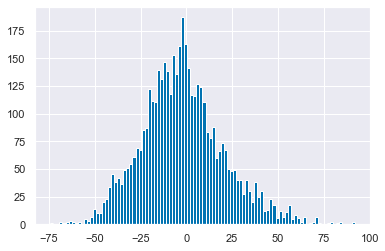

In [48]:
MCP_vals = MCP_vals.drop_duplicates()

Automatically created module for IPython interactive environment
LLE: 19 sec
LTSA: 21 sec
Hessian LLE: 23 sec
Modified LLE: 22 sec
Isomap: 25 sec
MDS: 25 sec
SE: 21 sec
t-SNE: 48 sec


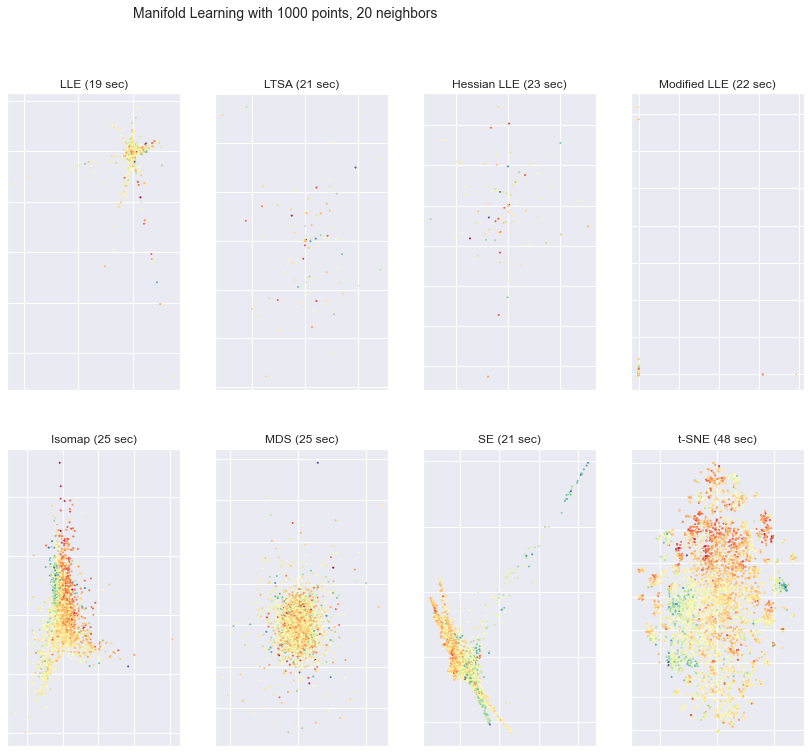

Wall time: 3min 25s


In [66]:
%%time
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

# n_points = 1000
# X, color = datasets.make_s_curve(n_points, random_state=0)

X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_neighbors = 20
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 12))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# # Add 3d scatter plot
# ax = fig.add_subplot(251, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='dense')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=20, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=1)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

t-SNE: 29 sec


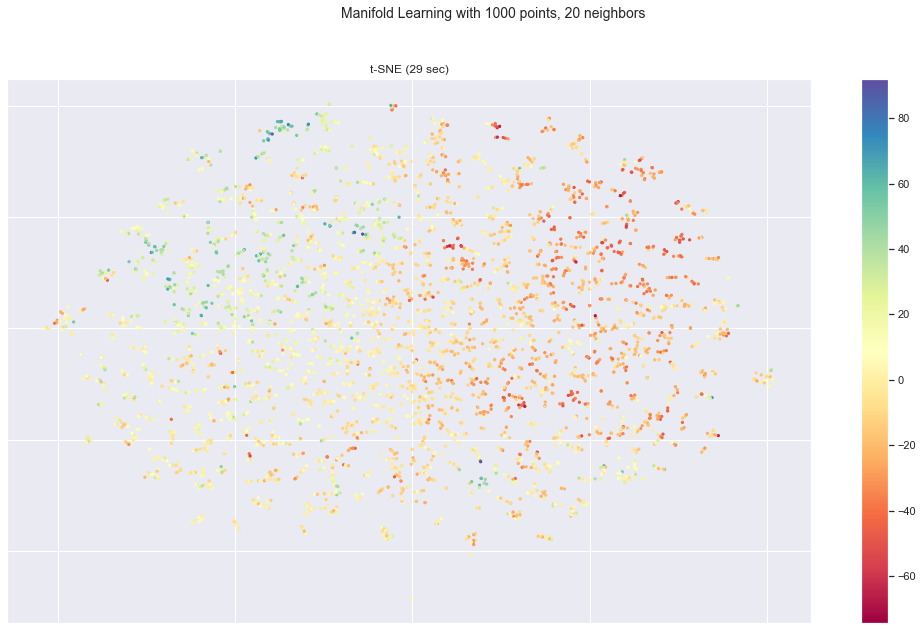

In [70]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 10))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=5)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=5)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 49 sec


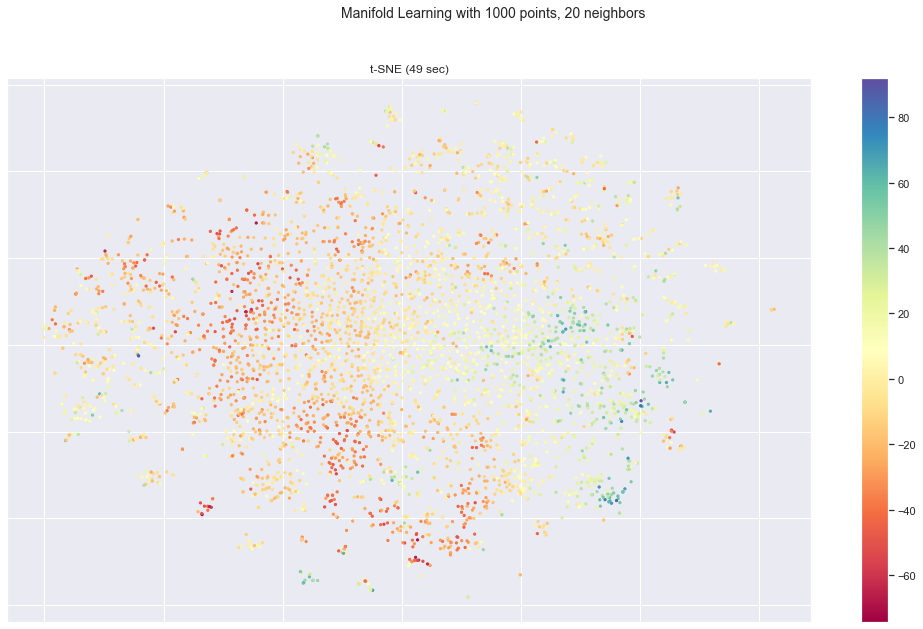

In [71]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=50)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=5)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 63 sec


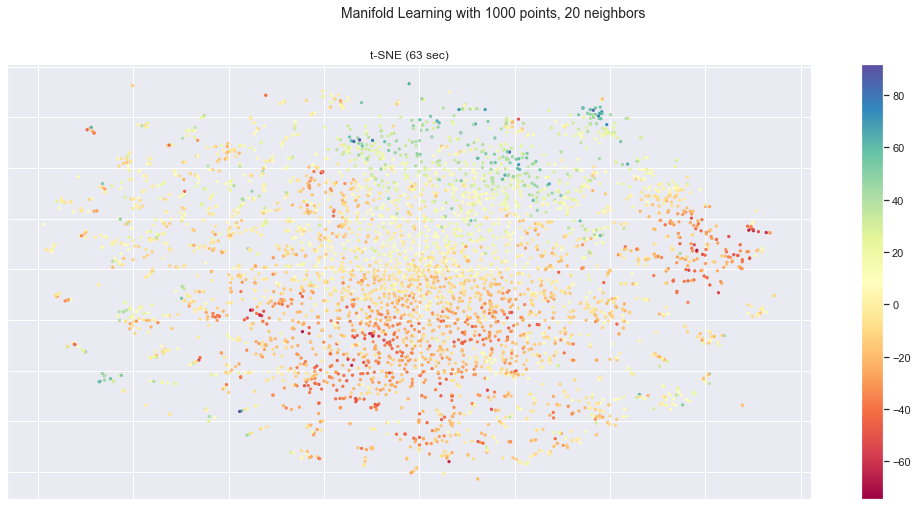

In [72]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=100)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=5)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 2.5e+02 sec


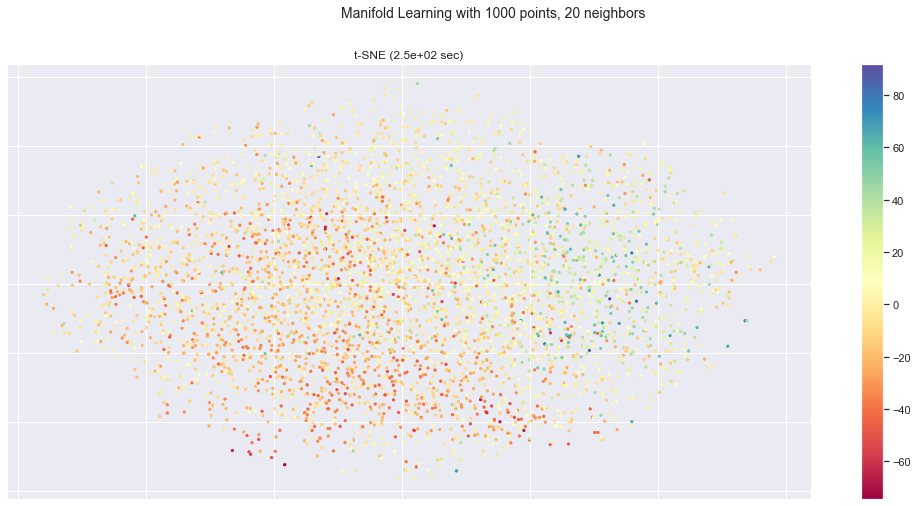

In [73]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 3

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=100)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=5)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 66 sec


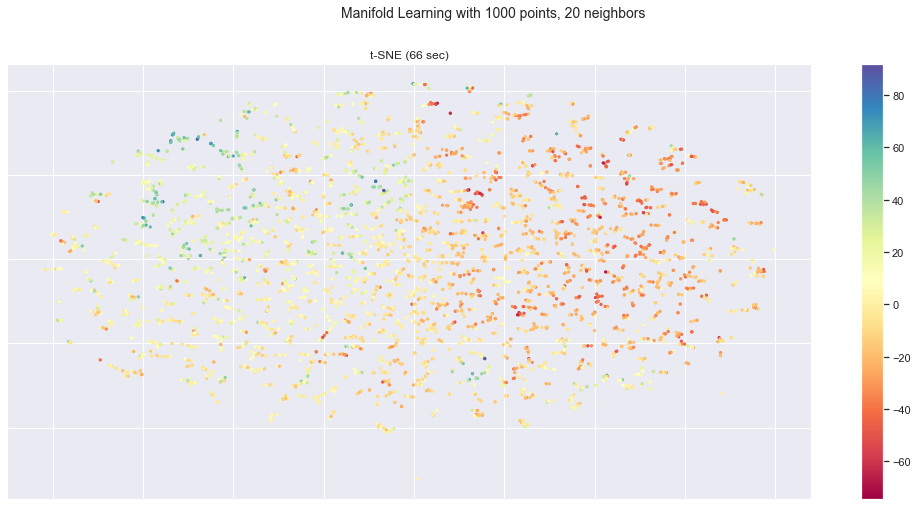

In [74]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=3)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=5)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 67 sec


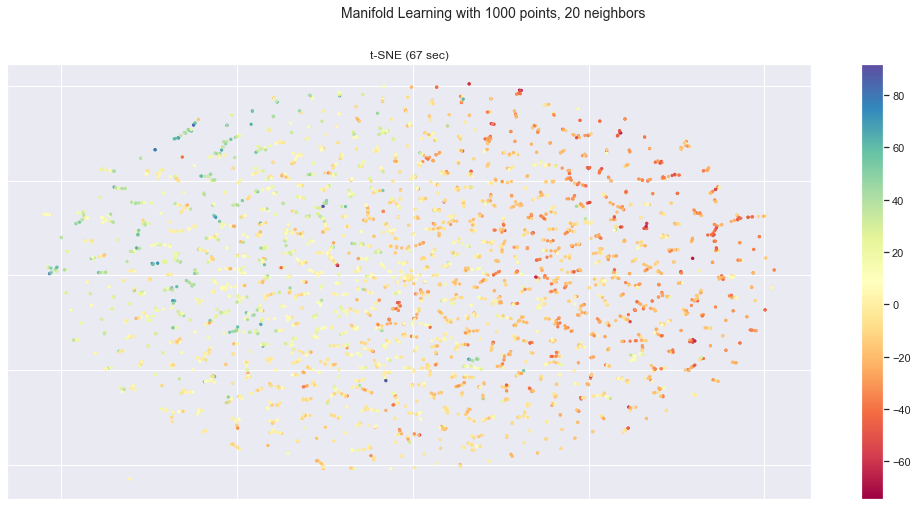

In [75]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=1)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=5)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 84 sec


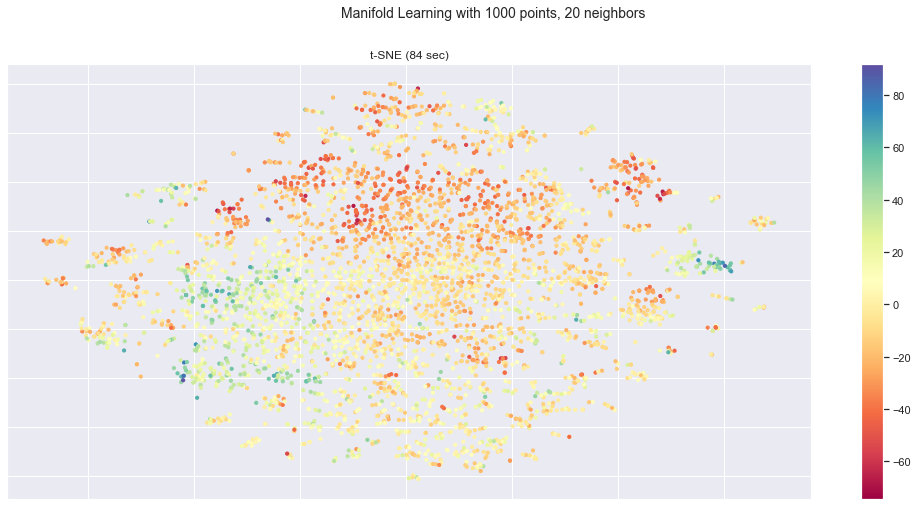

In [76]:
X = decomp_std.values#MCP_vals.values
color = MCP_vals["right-left ideological index(rile)"]
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=30)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
scat = ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral,s=10)
fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 47 sec


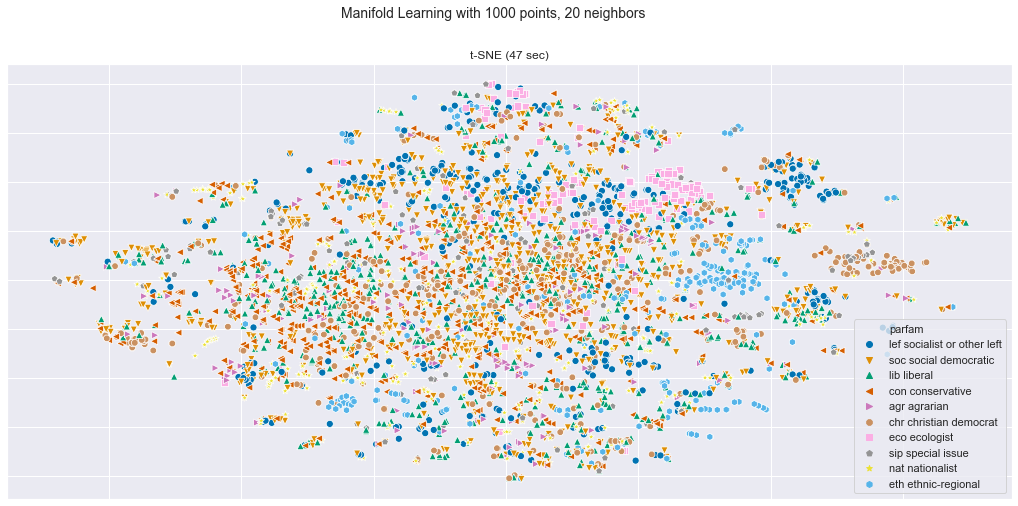

In [86]:
X = decomp_std.values#MCP_vals.values
# color = MCP_vals["right-left ideological index(rile)"]
parfam = manifesto_project.loc[MCP_vals.index,"parfam"]
parfam = parfam.replace("div divers alliance",np.nan).replace("mi missing information",np.nan).cat.remove_unused_categories()
color = parfam
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=30)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
scat = sns.scatterplot(Y[:, 0], Y[:, 1], hue=color, style=color, s=50, markers=filled_markers)
# cmap=plt.cm.Spectral
# fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 27 sec


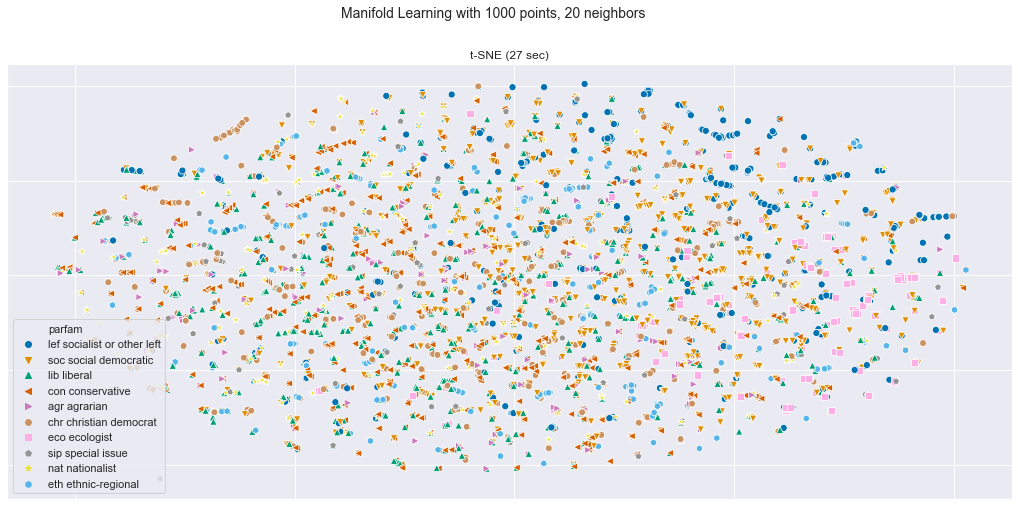

In [88]:
X = decomp_std.values#MCP_vals.values
# color = MCP_vals["right-left ideological index(rile)"]
parfam = manifesto_project.loc[MCP_vals.index,"parfam"]
parfam = parfam.replace("div divers alliance",np.nan).replace("mi missing information",np.nan).cat.remove_unused_categories()
color = parfam
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=1)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
scat = sns.scatterplot(Y[:, 0], Y[:, 1], hue=color, style=color, s=50, markers=filled_markers)
# cmap=plt.cm.Spectral
# fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

In [ ]:
X = decomp_std.values#MCP_vals.values
# color = MCP_vals["right-left ideological index(rile)"]
parfam = manifesto_project.loc[MCP_vals.index,"parfam"]
parfam = parfam.replace("div divers alliance",np.nan).replace("mi missing information",np.nan).cat.remove_unused_categories()
color = parfam
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=1)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
scat = sns.scatterplot(Y[:, 0], Y[:, 1], hue=color, style=color, s=50, markers=filled_markers)
# cmap=plt.cm.Spectral
# fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 73 sec


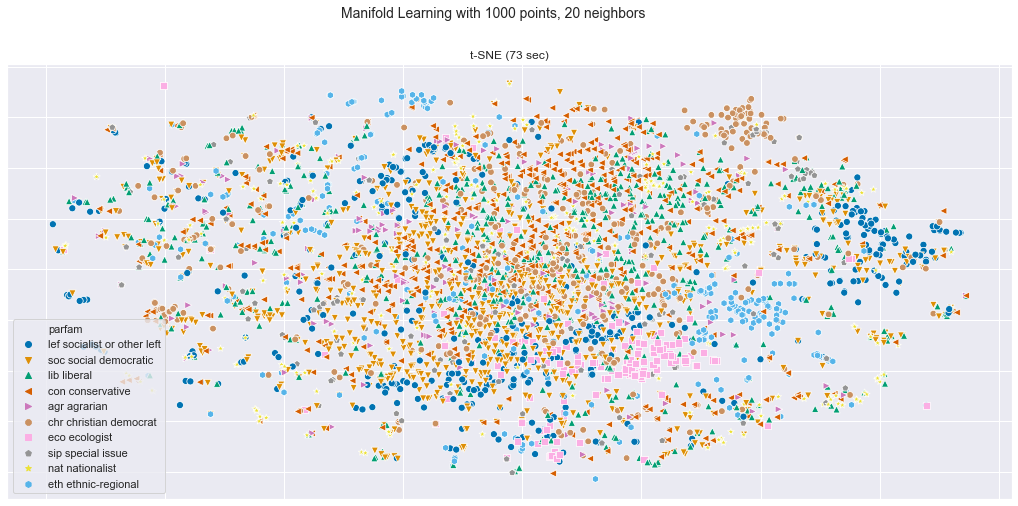

In [89]:
X = decomp_std.values#MCP_vals.values
# color = MCP_vals["right-left ideological index(rile)"]
parfam = manifesto_project.loc[MCP_vals.index,"parfam"]
parfam = parfam.replace("div divers alliance",np.nan).replace("mi missing information",np.nan).cat.remove_unused_categories()
color = parfam
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=100)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
scat = sns.scatterplot(Y[:, 0], Y[:, 1], hue=color, style=color, s=50, markers=filled_markers)
# cmap=plt.cm.Spectral
# fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

t-SNE: 82 sec


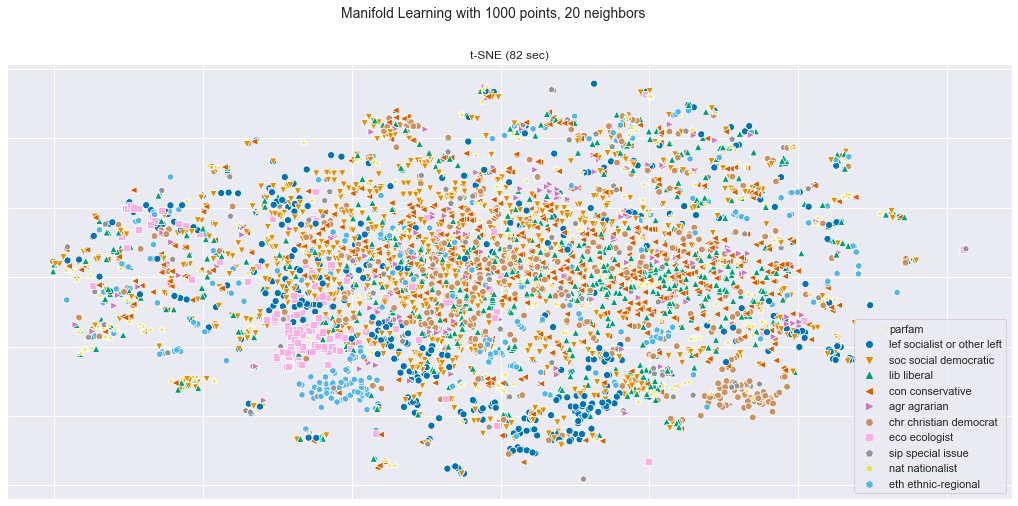

In [92]:
X = decomp_std.values#MCP_vals.values
# color = MCP_vals["right-left ideological index(rile)"]
parfam = manifesto_project.loc[MCP_vals.index,"parfam"]
parfam = parfam.replace("div divers alliance",np.nan).replace("mi missing information",np.nan).cat.remove_unused_categories()
color = parfam
n_components = 2

# Create figure
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

man = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0, perplexity=50)
sns.set();
sns.set_palette("colorblind")

t0 = time()
Y = man.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
ax = plt.gca()
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
scat = sns.scatterplot(Y[:, 0], Y[:, 1], hue=color, style=color, s=50, markers=filled_markers)
# cmap=plt.cm.Spectral
# fig.colorbar(scat)
ax.set_title("%s (%.2g sec)" % (label, t1 - t0));
ax.xaxis.set_major_formatter(NullFormatter());
ax.yaxis.set_major_formatter(NullFormatter());
ax.axis('tight');

In [87]:
manifesto_project#.loc[MCP_vals.index,"parfam"]

country   countryname      oecdmember          eumember  \
id_perm                                                                 
JN1LZH         sweden        Sweden  no oecd member  no eu membership   
CMR7F6         sweden        Sweden  no oecd member  no eu membership   
Z6OL6C         sweden        Sweden  no oecd member  no eu membership   
YMKVN2         sweden        Sweden  no oecd member  no eu membership   
U4SCRD         sweden        Sweden  no oecd member  no eu membership   
...               ...           ...             ...               ...   
FYLAK1   south africa  South Africa  no oecd member  no eu membership   
SES5XV   south africa  South Africa  no oecd member  no eu membership   
MEH5KV   south africa  South Africa  no oecd member  no eu membership   
NU5PXG   south africa  South Africa  no oecd member  no eu membership   
VKSFXI   south africa  South Africa  no oecd member  no eu membership   

             edate    date   party                       partyname  \
id_perm                                                              
JN1LZH  1944-09-17  194409   11220       Communist Party of Sweden   
CMR7F6  1944-09-17  194409   11320  Social Democratic Labour Party   
Z6OL6C  1944-09-17  194409   11420                  People’s Party   
YMKVN2  1944-09-17  194409   11620                     Right Party   
U4SCRD  1944-09-17  194409   11810                  Agrarian Party   
...            ...     ...     ...                             ...   
FYLAK1  2014-05-07  201405  181210       Economic Freedom Fighters   
SES5XV  2014-05-07  201405  181310       African National Congress   
MEH5KV  2014-05-07  201405  181411             Democratic Alliance   
NU5PXG  2014-05-07  201405  181420          Congress of the People   
VKSFXI  2014-05-07  201405  181910           Inkatha Freedom Party   

        partyabbrev                       parfam  ... per608_2 per608_3  \
id_perm                                           ...                     
JN1LZH          SKP  lef socialist or other left  ...      NaN      NaN   
CMR7F6          SAP        soc social democratic  ...      NaN      NaN   
Z6OL6C           FP                  lib liberal  ...      NaN      NaN   
YMKVN2                          con conservative  ...      NaN      NaN   
U4SCRD                              agr agrarian  ...      NaN      NaN   
...             ...                          ...  ...      ...      ...   
FYLAK1          EEF  lef socialist or other left  ...      NaN      NaN   
SES5XV          ANC        soc social democratic  ...      NaN      NaN   
MEH5KV           DA                  lib liberal  ...      NaN      NaN   
NU5PXG         COPE                  lib liberal  ...      NaN      NaN   
VKSFXI          IFP          eth ethnic-regional  ...      NaN      NaN   

         per703_1  per703_2    rile  planeco markeco  welfare  intpeace  \
id_perm                                                                   
JN1LZH        NaN       NaN   9.600    1.900   1.900    0.000     1.900   
CMR7F6        NaN       NaN -37.800    3.300   2.200   33.400     5.600   
Z6OL6C        NaN       NaN   9.500    3.200   6.400   14.300     1.600   
YMKVN2        NaN       NaN  28.000    1.800  22.800   10.600     0.000   
U4SCRD        NaN       NaN  23.810    0.000  19.048    0.000     4.762   
...           ...       ...     ...      ...     ...      ...       ...   
FYLAK1        NaN       NaN -27.799    3.918   0.000   18.843     0.187   
SES5XV        NaN       NaN -31.926    3.885   0.000   18.412     0.169   
MEH5KV        NaN       NaN  -8.120    3.134   0.427   13.675     0.142   
NU5PXG        NaN       NaN -32.812    1.042   0.000   10.938     2.083   
VKSFXI        NaN       NaN  -7.724    0.813   0.000    6.098     0.000   

         datasetversion  
id_perm                  
JN1LZH            2019b  
CMR7F6            2019b  
Z6OL6C            2019b  
YMKVN2            2019b  
U4SCRD            2019b  
...                